In [2]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
## Loading in Data

# Top 200 song consumption
df = pd.read_csv('../../raw_data/beema/cleaned_data/top_200_song_consumption_cleaned.csv')

# Group by 'Song' and keep the row with the highest 'Weeks On Chart'
unique_songs = df.loc[df.groupby('Song')['Weeks On Chart'].idxmax()]
unique_songs = unique_songs.reset_index(drop=True)

# Top 25% of Weeks on Chart
top_songs = unique_songs[unique_songs['Weeks On Chart'] >= 20]

# Bottom 75% of Weeks on Chart
bottom_songs = unique_songs[unique_songs['Weeks On Chart'] < 20]

# Camille's large dataset
all_songs = pd.read_csv('../../raw_data/camille/songs_with_attributes_and_lyrics.csv')
# Drop duplicates
all_songs = all_songs.drop_duplicates(subset=['name'])
# Add duration in s: convert ms to seconds
all_songs['duration_s'] = all_songs['duration_ms'] / 1000
# Merge two datasets
merged_dataset_top_25 = pd.merge(top_songs, all_songs, how='inner', left_on='Song', right_on='name')
merged_dataset_top_25.drop(columns='lyrics', inplace=True)

# Columns to be used for analysis later
song_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_s"
]

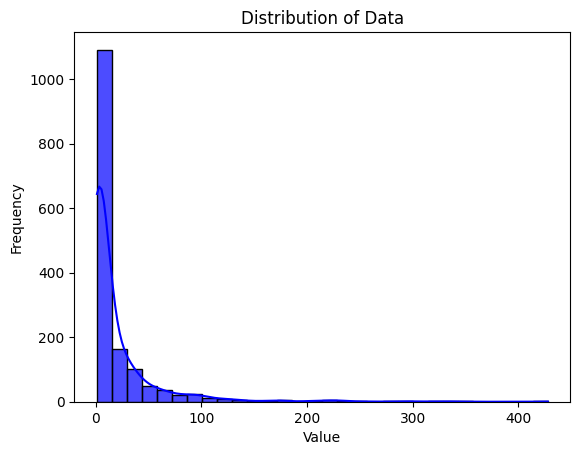

Summary stats:
 count    1543.000000
mean       19.156189
std        38.582145
min         1.000000
25%         1.000000
50%         4.000000
75%        20.000000
max       428.000000
Name: Weeks On Chart, dtype: float64


In [4]:
## Distribution of number of Weeks On Chart

# Data
data = unique_songs['Weeks On Chart']

# Create the plot
# plt.figure(figsize=(16, 8)) # Change if needed
sns.histplot(data, bins=30, kde=True, color='blue', alpha=0.7)  # kde=True adds a density curve
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Summary stats of distribution
print('Summary stats:\n', data.describe())

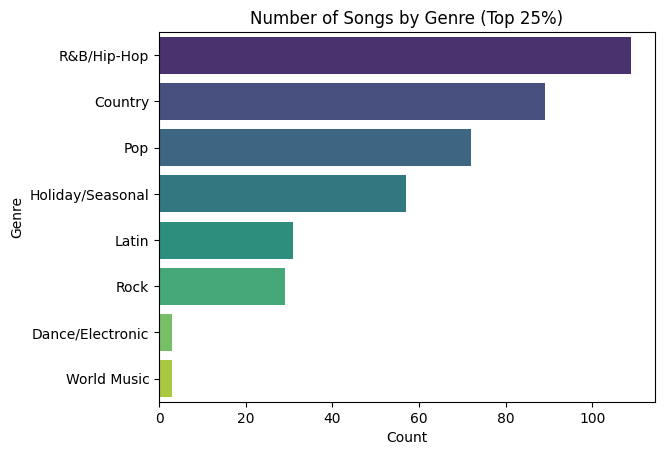

In [9]:
## Count of Genres in the Top 25% of Weeks On Chart

data_genre = top_songs.groupby('Genre')['Song'].count()

# Reset index to convert the Series to a DataFrame
data_genre_df = data_genre.reset_index()
data_genre_df.columns = ['Genre', 'Count']
data_genre_df = data_genre_df.sort_values(by='Count', ascending=False)

# Create the bar plot
sns.barplot(x='Count', y='Genre', data=data_genre_df, hue='Genre', palette='viridis', dodge=False)

# Add title and labels
# plt.figure(figsize=(16, 8)) # Change if needed
plt.title('Number of Songs by Genre (Top 25%)')
plt.xlabel('Count')
plt.ylabel('Genre')

# Show the plot
plt.show()

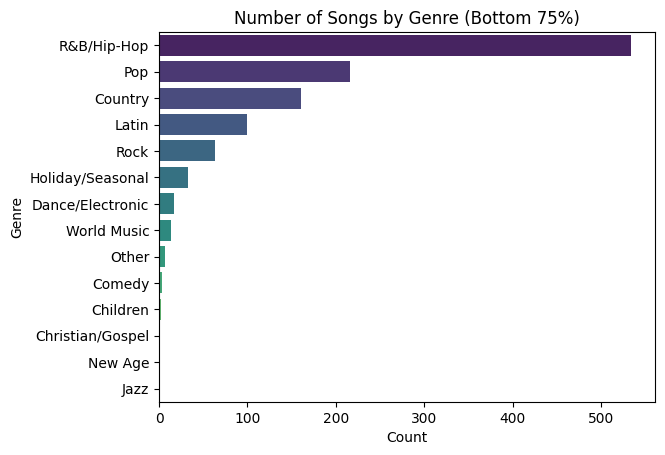

In [5]:
## Count of Genres in the Bottom 75% of Weeks On Chart

data_genre = bottom_songs.groupby('Genre')['Song'].count()

# Reset index to convert the Series to a DataFrame
data_genre_df = data_genre.reset_index()
data_genre_df.columns = ['Genre', 'Count']
data_genre_df = data_genre_df.sort_values(by='Count', ascending=False)

# Create the bar plot
sns.barplot(x='Count', y='Genre', data=data_genre_df, hue='Genre', palette='viridis', dodge=False)

# Add title and labels
# plt.figure(figsize=(16, 8)) # Change if needed
plt.title('Number of Songs by Genre (Bottom 75%)')
plt.xlabel('Count')
plt.ylabel('Genre')

# Show the plot
plt.show()

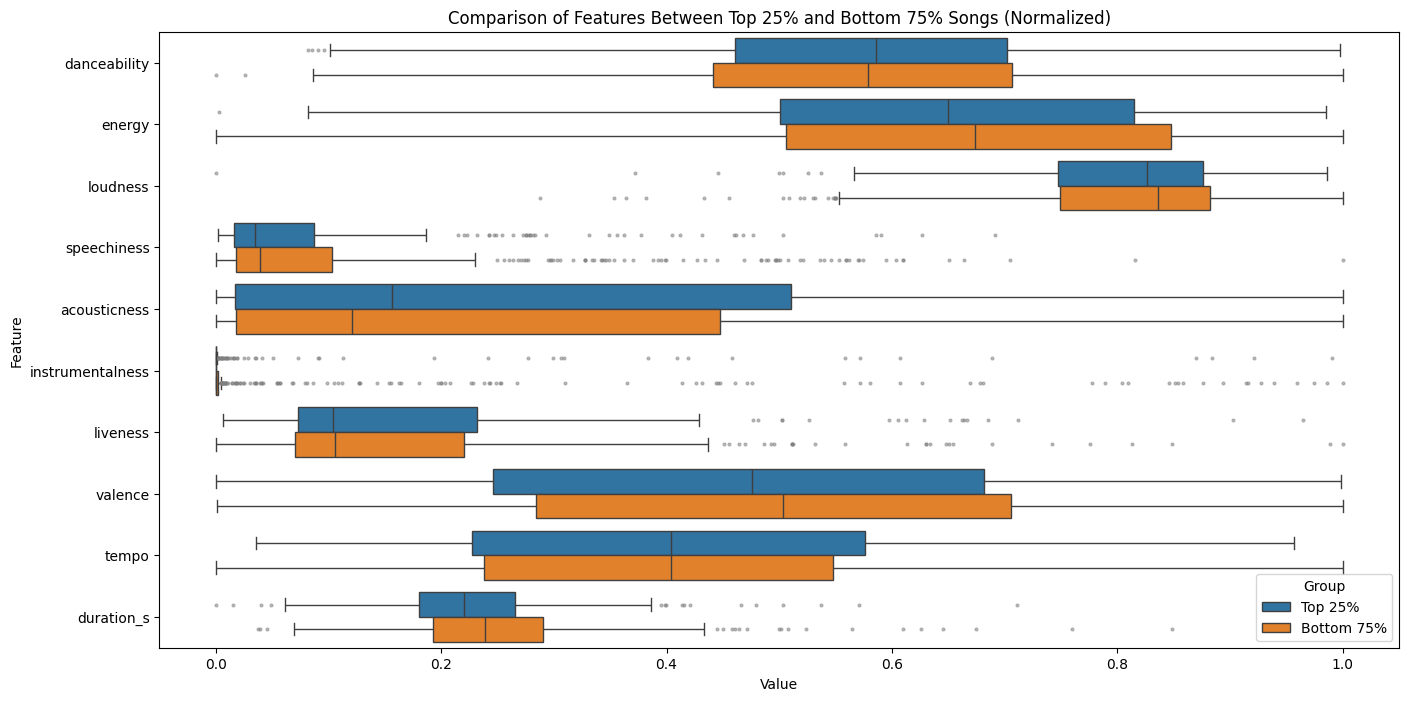

In [22]:
## Similar features between Top 25% and Bottom 75% Charted Songs

# Combine both datasets before normalization
top_songs_merged = merged_dataset_top_25[song_features]
bottom_songs_merged = all_songs.loc[all_songs['name'].isin(bottom_songs['Song']), song_features]

# Ensure consistent normalization
all_data = pd.concat([top_songs_merged, bottom_songs_merged])

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(all_data), columns=song_features)

# Split back into respective groups
normalized_top_songs = normalized_data.iloc[:len(top_songs_merged), :].copy()
normalized_bottom_songs = normalized_data.iloc[len(top_songs_merged):, :].copy()

# Melt datasets to make them easier to visualize
top_songs_melted = normalized_top_songs.melt(var_name='Feature', value_name='Value')
bottom_songs_melted = normalized_bottom_songs.melt(var_name='Feature', value_name='Value')

# Add a group column
top_songs_melted['Group'] = 'Top 25%'
bottom_songs_melted['Group'] = 'Bottom 75%'

# Combine the datasets
combined_data = pd.concat([top_songs_melted, bottom_songs_melted])

# Create box plots
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=combined_data, 
    x='Value', 
    y='Feature', 
    hue='Group',
    flierprops={
        'marker':'o', 
        'markersize':2,  # Smaller marker size
        'alpha':0.5,     # Add some transparency
        'markerfacecolor':'gray', 
        'markeredgecolor':'gray'
    }
)
plt.title(r'Comparison of Features Between Top 25% and Bottom 75% Songs (Normalized)')
plt.show()


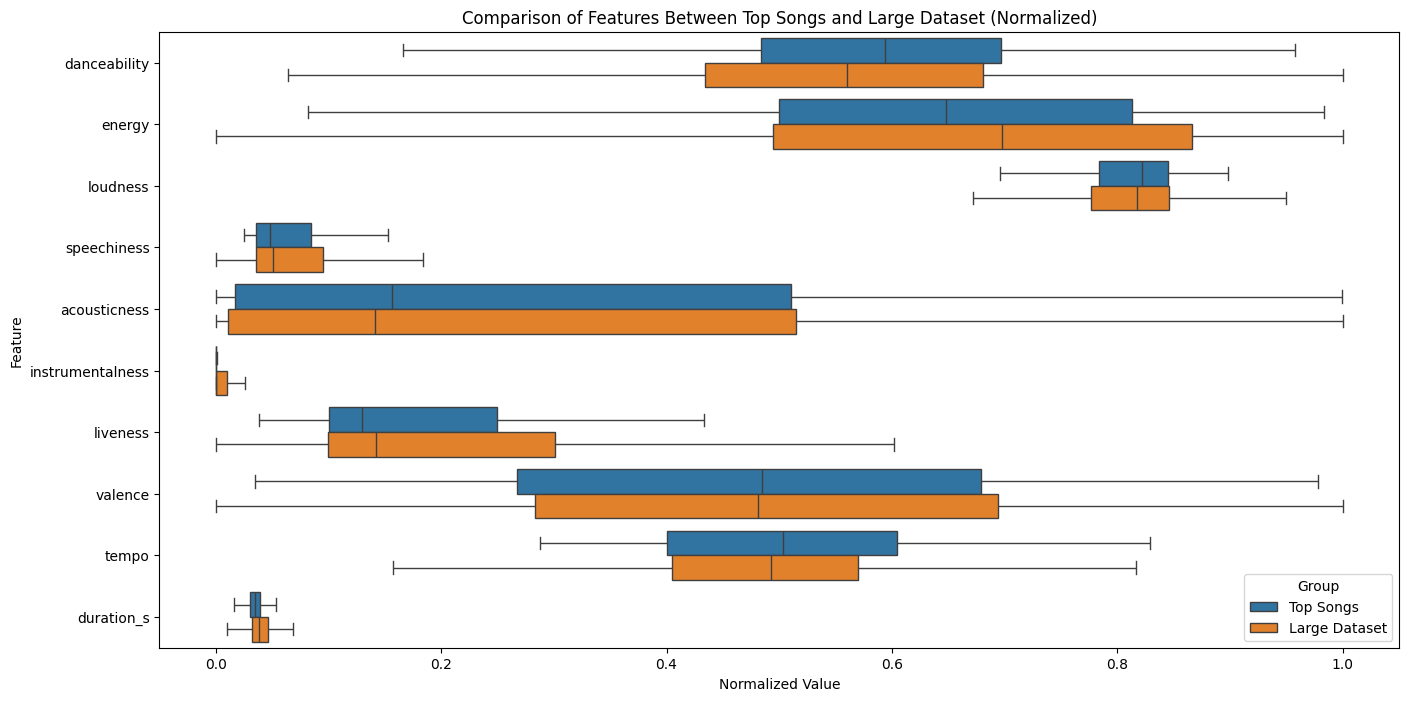

In [24]:
## Similar features Between All Charted Songs and Large Dataset

# Combine the data (all_songs and merged_dataset_top_25) before normalization
all_data = pd.concat([all_songs[song_features], merged_dataset_top_25[song_features]])

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(all_data), columns=song_features)

# Split back into large dataset (all_songs) and top songs (merged_dataset_top_25)
normalized_all_songs = normalized_data.iloc[:len(all_songs), :].copy()
normalized_top_songs = normalized_data.iloc[len(all_songs):, :].copy()

# Melt datasets to make them easier to visualize
all_songs_melted = normalized_all_songs.melt(var_name='Feature', value_name='Value')
top_songs_melted = normalized_top_songs.melt(var_name='Feature', value_name='Value')

# Add a group column
all_songs_melted['Group'] = 'Large Dataset'
top_songs_melted['Group'] = 'Top Songs'

# Combine the datasets
combined_data = pd.concat([top_songs_melted, all_songs_melted])

# Create box plots
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=combined_data, 
    x='Value', 
    y='Feature', 
    hue='Group',
    showfliers=False # Remove outliers
)
plt.title('Comparison of Features Between Top Songs and Large Dataset (Normalized)')
plt.xlabel('Normalized Value')
plt.ylabel('Feature')
plt.show()

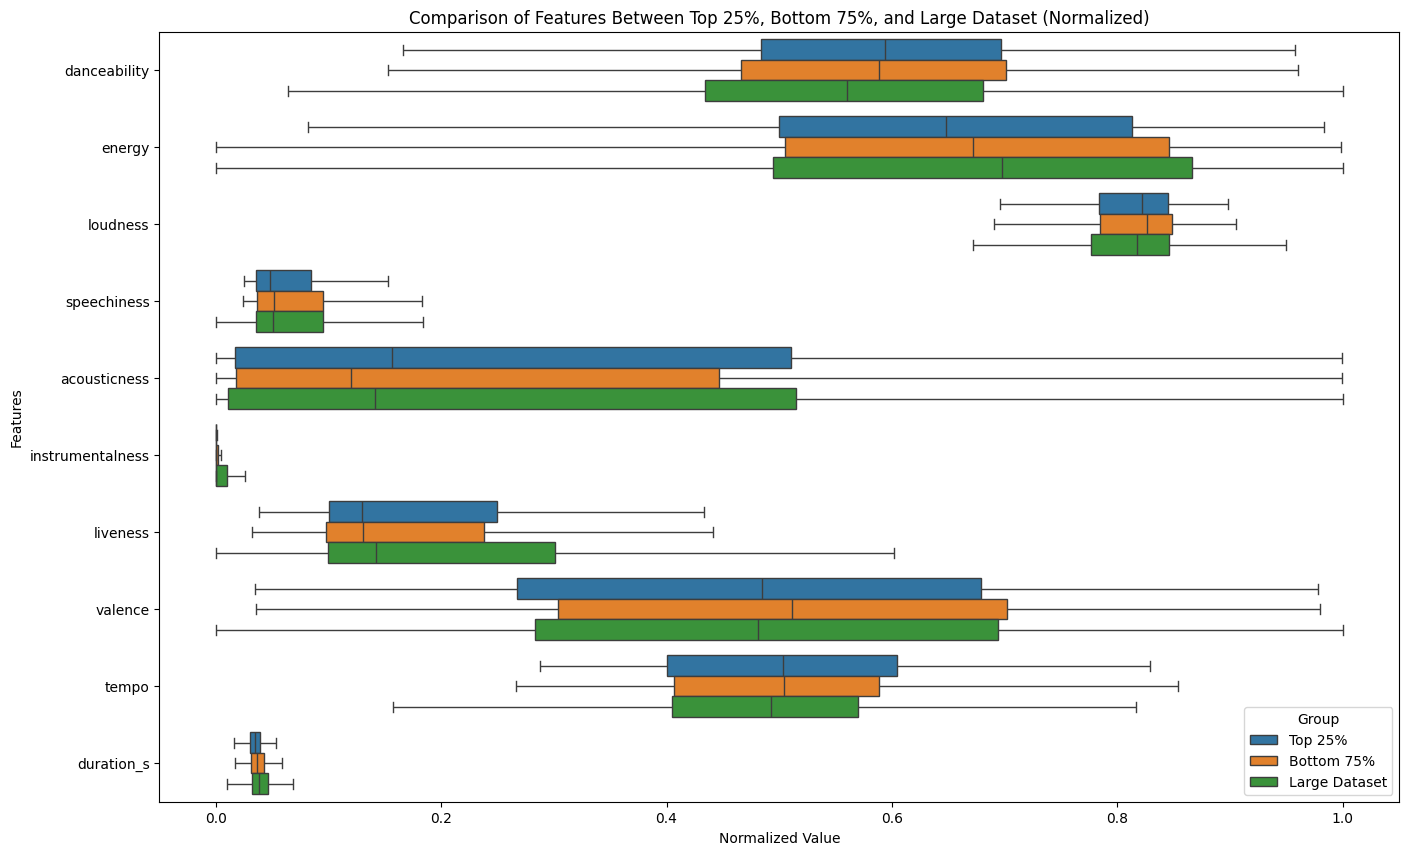

In [25]:
## Similarity of all three sets

# Combine all datasets before normalization
top_songs_merged = merged_dataset_top_25[song_features]
bottom_songs_merged = all_songs.loc[all_songs['name'].isin(bottom_songs['Song']), song_features]
large_dataset = all_songs[song_features]

# Ensure consistent normalization
all_data = pd.concat([top_songs_merged, bottom_songs_merged, large_dataset])

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(all_data), columns=song_features)

# Split back into respective groups
normalized_top_songs = normalized_data.iloc[:len(top_songs_merged), :].copy()
normalized_bottom_songs = normalized_data.iloc[len(top_songs_merged):len(top_songs_merged) + len(bottom_songs_merged), :].copy()
normalized_large_dataset = normalized_data.iloc[len(top_songs_merged) + len(bottom_songs_merged):, :].copy()

# Melt datasets to make them easier to visualize
top_songs_melted = normalized_top_songs.melt(var_name='Feature', value_name='Value')
bottom_songs_melted = normalized_bottom_songs.melt(var_name='Feature', value_name='Value')
large_dataset_melted = normalized_large_dataset.melt(var_name='Feature', value_name='Value')

# Add a group column
top_songs_melted['Group'] = 'Top 25%'
bottom_songs_melted['Group'] = 'Bottom 75%'
large_dataset_melted['Group'] = 'Large Dataset'

# Combine the datasets
combined_data = pd.concat([top_songs_melted, bottom_songs_melted, large_dataset_melted])

# Create box plots
plt.figure(figsize=(16, 10))
sns.boxplot(
    data=combined_data, 
    x='Value', 
    y='Feature', 
    hue='Group',
    showfliers=False # Remove outliers
)
plt.title(r'Comparison of Features Between Top 25%, Bottom 75%, and Large Dataset (Normalized)')
plt.xlabel('Normalized Value')
plt.ylabel('Features')
plt.show()